In [1]:
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime
import os
import matplotlib.pyplot as plt
from metpy.plots import SkewT, Hodograph
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

-----------------
#### It seems as though there are small differences in the times in the gridded file and original soundings
*Observed Sounding Times on 10 November 2018 (IOP4)*
- 1500 UTC
- 1602 UTC
- 1704 UTC
- 1806 UTC
- 2000 UTC
- **2031 UTC**
- **2134 UTC**
- 2259 UTC

*Times Available in Gridded Files on 10 November 2018 (IOP4)*
- 1500 UTC
- 1602 UTC
- 1704 UTC
- 1806 UTC
- 2000 UTC
- **2001 UTC**
- **2104 UTC**
- 2209 UTC

#### The times highlighted were also identified in the mobile asset report as cold pool soundings - two of the more important soundings of the day
------------------------

#### Bring in the sounding datasets

In [2]:
# Using gridded times

# CSU Soundings
csu_ds = xr.open_dataset('../Data/soundings/CSU_griddedsounding.nc')

# UIUC Soundings
ui2_ds = xr.open_dataset('../Data/soundings/UIUC2_griddedsounding.nc')

#### Decide which time you would like to use

In [3]:
year = 2018
month = 11
day = 10
hour = 20
minute = 1
select_time = np.datetime64(datetime(year, month, day, hour, minute))

### Create a Skew-T including a hodograph to visualize data

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:154: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


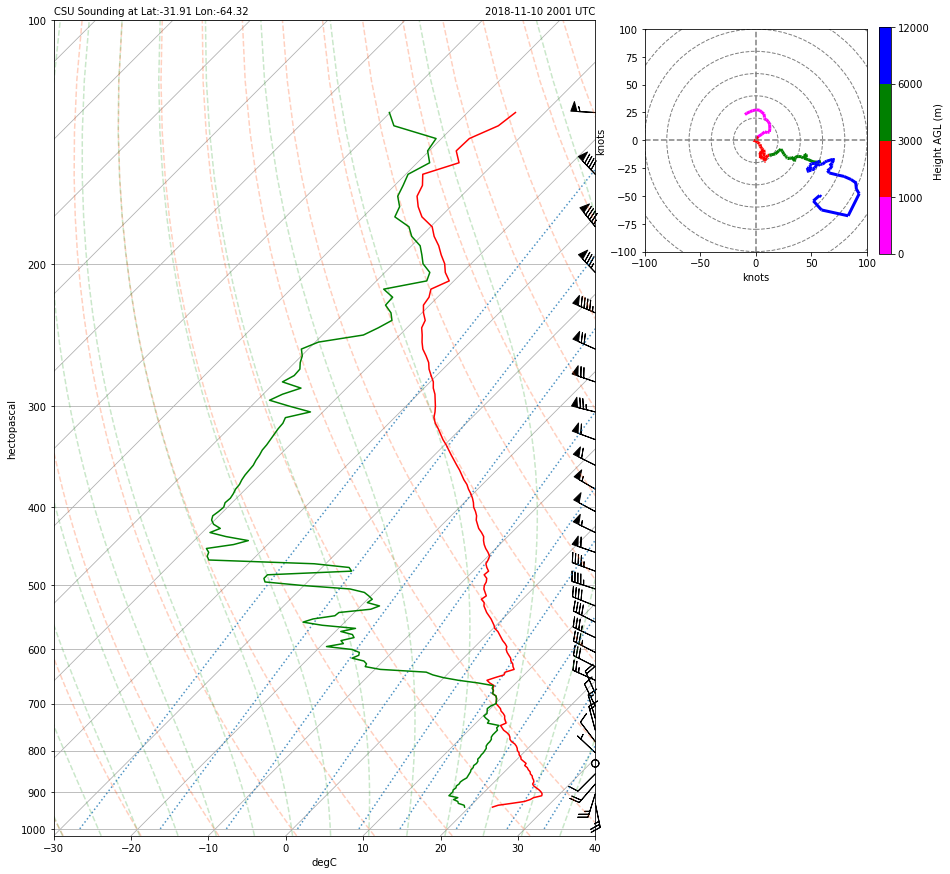

In [4]:
ds = csu_ds.sel(launch_time = select_time).dropna('pressure').squeeze()
 
# Bring in the temperature, dewpoint, and pressure of the sounding
T = ds['Temp'].values[:-2] * units.degC
Td = ds['Dewpt'].values[:-2] * units.degC
p = ds['pressure'].values[:-2] * units.hPa

# Bring in the wind components
u = (ds['Ucmp'].values[:-2] * units('m/s')).to('knots')
v = (ds['Vcmp'].values[:-2] * units('m/s')).to('knots')
    
# Bring in wind speed
wind_speed = mpcalc.wind_speed(u, v)
    
# Finds Height above ground level
agl = (ds['Alt'].values[:-2] - ds['Alt'].values[-1]) * units('meter')

# Bring in the time of environmental sounding
time_stamp = pd.to_datetime(ds.launch_time.values)
    
# Change default size to fit dimensions of a typical Skew-T
fig = plt.figure(figsize=(15, 15))
    
#Sets up the figure
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

# Plot the environment temperature and dewpoint
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::5], u[::5], v[::5], y_clip_radius=0.03)

# Set appropriate axes
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add labels/titles
plt.title('CSU Sounding at Lat:{0:.2f} Lon:{1:.2f}'.format(ds.Lat.values[-1], ds.Lon.values[-1]), loc='left', size=10)
plt.title(time_stamp.strftime('%Y-%m-%d %H%M UTC'), fontsize=10, loc='right')

# Create a hodograph
# figure and put it in the upper right hand corner.
ax_hod = fig.add_subplot(gs[0, -1])
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=20)
    
# Plot hodograph and contour based on height above ground level
cs = h.plot_colormapped(u, v, agl, intervals=np.array([0, 1, 3, 6, 12]) * units.km, colors=['magenta', 'red', 'green', 'blue'])
    
# Add a colorbar
fig.colorbar(cs, ax=ax_hod, use_gridspec=True, label='Height AGL (m)', fraction=0.046)

# Add some axes labels
ax_hod.set_xlabel('knots', size=10)
ax_hod.set_ylabel('knots', size=10)
    
# Save the figure
plt.show()

### Now that we looked at a single sounding, we can go ahead and create plots for all the soundings and save them into a single directory

In [5]:
for time in csu_ds.launch_time.values:
    # Select the specific time from the dataset
    ds = csu_ds.sel(launch_time = time).dropna('pressure').squeeze()
    # 
    # Bring in the temperature, dewpoint, and pressure of the sounding
    T = ds['Temp'].values[:-2] * units.degC
    Td = ds['Dewpt'].values[:-2] * units.degC
    p = ds['pressure'].values[:-2] * units.hPa

    # Bring in the wind components
    u = (ds['Ucmp'].values[:-2] * units('m/s')).to('knots')
    v = (ds['Vcmp'].values[:-2] * units('m/s')).to('knots')
    
    # Bring in wind speed
    wind_speed = mpcalc.wind_speed(u, v)
    
    # Finds Height above ground level
    agl = (ds['Alt'].values[:-2] - ds['Alt'].values[-1]) * units('meter')

    # Bring in the time of environmental sounding
    time_stamp = pd.to_datetime(ds.launch_time.values)
    
    # Change default size to fit dimensions of a typical Skew-T
    fig = plt.figure(figsize=(15, 15))
    
    #Sets up the figure
    gs = gridspec.GridSpec(3, 3)
    skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

    # Plot the environment temperature and dewpoint
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p[::5], u[::5], v[::5], y_clip_radius=0.03)

    # Set appropriate axes
    skew.ax.set_xlim(-30, 40)
    skew.ax.set_ylim(1020, 100)

    # Add the relevant special lines to plot throughout the figure
    skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                           alpha=0.25, color='orangered')
    skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                             alpha=0.25, color='tab:green')
    skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                           linestyle='dotted', color='tab:blue')

    # Add labels/titles
    plt.title('CSU Sounding at Lat:{0:.2f} Lon:{1:.2f}'.format(ds.Lat.values[-1], ds.Lon.values[-1]), loc='left', size=10)
    plt.title(time_stamp.strftime('%Y-%m-%d %H%M UTC'), fontsize=10, loc='right')

    # Create a hodograph
    # figure and put it in the upper right hand corner.
    ax_hod = fig.add_subplot(gs[0, -1])
    h = Hodograph(ax_hod, component_range=80.)
    h.add_grid(increment=20)
    
    # Plot hodograph and contour based on height above ground level
    cs = h.plot_colormapped(u, v, agl, intervals=np.array([0, 1, 3, 6, 12]) * units.km, colors=['magenta', 'red', 'green', 'blue'])
    
    # Add a colorbar
    fig.colorbar(cs, ax=ax_hod, use_gridspec=True, label='Height AGL (m)', fraction=0.046)

    # Add some axes labels
    ax_hod.set_xlabel('knots', size=10)
    ax_hod.set_ylabel('knots', size=10)
    
    # Save the figure
    plt.savefig('../Soundings/CSU/QC/CSU_Sounding_'+time_stamp.strftime('%Y%m%d_%H%MZ')+'.png', dpi=200)
    plt.close()

/data/keeling/a/mgrover4/a/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:144: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


---
### Next, let's look at a specific date - 10 November 2018 - and analyze an environmental sounding in addtion to a cold pool sounding

In [6]:
# Create a list of available CSU times
csu_times = csu_ds['launch_time'].values
ui2_times = ui2_ds['launch_time'].values

In [7]:
# Select an environment sounding
env_sounding = csu_ds.sel(launch_time = '2018-11-10T18:06:00.000000000').dropna('pressure').squeeze()

# Select a cold pool sounding
cold_pool_sounding = csu_ds.sel(launch_time = '2018-11-10T20:01:00.000000000').dropna('pressure').squeeze()

# Make sure that pressure levels match 
env_sounding = env_sounding.sel({'pressure':cold_pool_sounding.pressure.values}, method='pad')
cold_pool_sounding = cold_pool_sounding.sel({'pressure':env_sounding.pressure.values})

### Bring in data for the environmental sounding

In [8]:
# Bring in the temperature, dewpoint, and pressure of the sounding
T_env = env_sounding['Temp'].values * units.degC
Td_env = env_sounding['Dewpt'].values * units.degC
p_env = env_sounding['pressure'].values * units.hPa
theta_env = mpcalc.potential_temperature(p_env, T_env)
theta_e_env = mpcalc.equivalent_potential_temperature(p_env, T_env, Td_env)
theta_w_env = mpcalc.virtual_potential_temperature(p_env, T_env,
                                               mpcalc.mixing_ratio_from_relative_humidity(mpcalc.relative_humidity_from_dewpoint(T_env, Td_env), T_env, p_env))
agl_env = (env_sounding['Alt'].values - env_sounding['Alt'].values[-1]) * units('meter')

# Bring in the wind direction/speed
sped_env = env_sounding['spd'].values * units('m/s')
dir_env = env_sounding['dir'].values * units('m/s')

# Bring in the wind components
u_env = env_sounding['Ucmp'].values * units('m/s')
v_env = env_sounding['Vcmp'].values * units('m/s')

# Bring in the time of environmental sounding
env_time = pd.to_datetime(env_sounding.launch_time.values)

### Bring in data for the cold pool sounding

In [9]:
# Bring in the temperature, dewpoint, and pressure of the sounding
T_cold = cold_pool_sounding['Temp'].values * units.degC
Td_cold = cold_pool_sounding['Dewpt'].values * units.degC
p_cold = cold_pool_sounding['pressure'].values * units.hPa
theta_cold = mpcalc.potential_temperature(p_cold, T_cold)
theta_e_cold = mpcalc.equivalent_potential_temperature(p_cold, T_cold, Td_cold)
theta_w_cold = mpcalc.virtual_potential_temperature(p_cold, T_cold,
                                                    mpcalc.mixing_ratio_from_relative_humidity(mpcalc.relative_humidity_from_dewpoint(T_cold, Td_cold), T_cold, p_cold))

agl_env = (env_sounding['Alt'].values - env_sounding['Alt'].values[-1]) * units('meter')

# Bring in the wind direction/speed
sped_cold = cold_pool_sounding['spd'].values * units('m/s')
dir_cold = cold_pool_sounding['dir'].values * units('m/s')

# Bring in the wind components
u_cold = cold_pool_sounding['Ucmp'].values * units('m/s')
v_cold = cold_pool_sounding['Vcmp'].values * units('m/s')

# Bring in the time of the cold pool sounding
cold_time = pd.to_datetime(cold_pool_sounding.launch_time.values)

### Create a Skew-T Diagram 

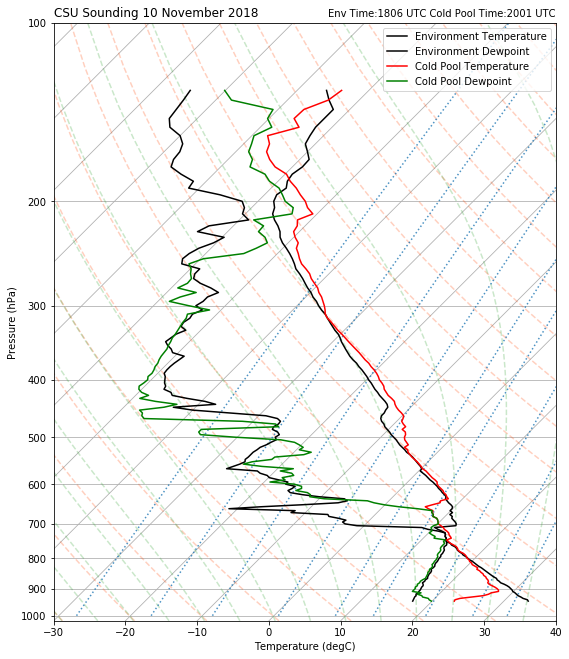

In [10]:
# Change default size to fit dimensions of a typical Skew-T
fig = plt.figure(figsize=(9, 11))

# Use MetPy plots to create a Skew-T diagram
skew = SkewT(fig, rotation=45)

# Plot the environment temperature and dewpoint
skew.plot(p_env, T_env, 'black', label='Environment Temperature')
skew.plot(p_env, Td_env, 'black', label='Environment Dewpoint')

# Plot the cold pool temperature and dewpoint
skew.plot(p_cold, T_cold, 'red', label='Cold Pool Temperature')
skew.plot(p_cold, Td_cold, 'green', label='Cold Pool Dewpoint')
#skew.plot_barbs(p_env[::5], u_env[::5], v_env[::5], y_clip_radius=0.03)

# Set appropriate axes
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add labels/titles
plt.xlabel('Temperature (degC)')
plt.ylabel('Pressure (hPa)')
plt.legend()
plt.title('CSU Sounding 10 November 2018', loc='left')
plt.title('Env Time:'+env_time.strftime('%H%M UTC')+' Cold Pool Time:'+cold_time.strftime('%H%M UTC'), fontsize=10, loc='right')
plt.savefig('CSU_10_Nov_ColdPool_Env.png', dpi=200)

Text(0.5, 1.0, 'CSU Sounding 10 November 2018')

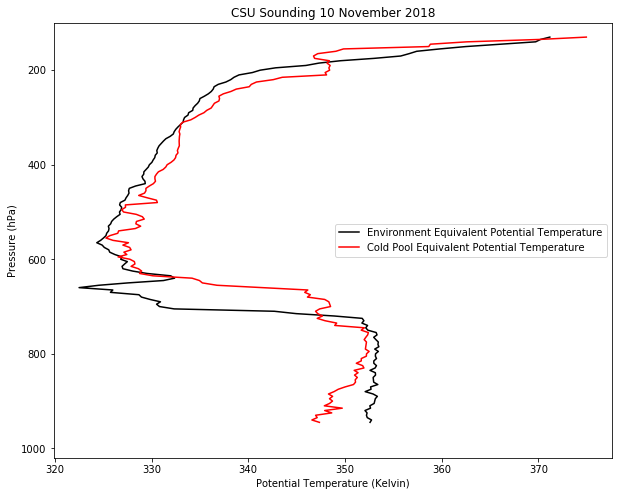

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
    
# Plot the Potential Temperature Values
ax.plot(theta_e_env, p_env, color = 'black', label='Environment Equivalent Potential Temperature')
ax.plot(theta_e_cold, p_cold, color = 'r', label='Cold Pool Equivalent Potential Temperature')
    
# Make sure the vertical pressure axis is descending as it goes up

# Add a label to the axis for Potential Temperature
ax.set_xlabel('Potential Temperature (Kelvin)')

# Add a label to the axis for Pressure
ax.set_ylabel('Pressure (hPa)')
plt.ylim(1020, 100)
plt.legend()
    
# Add a title including the sounding location and the time of the sounding
plt.title('CSU Sounding 10 November 2018')

Text(0.5, 1.0, 'CSU Sounding 10 November 2018')

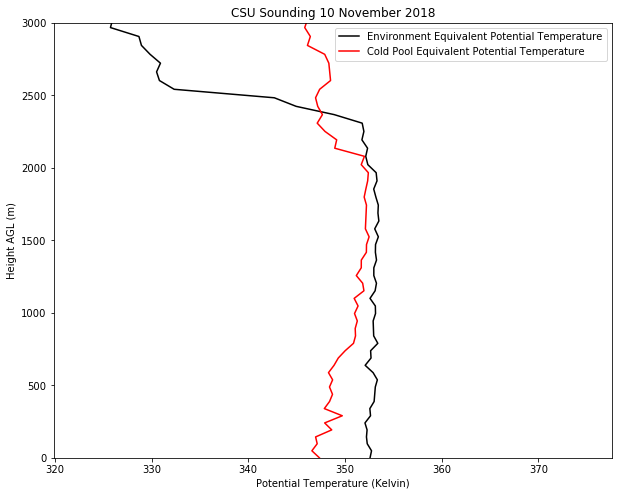

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
    
# Plot the Potential Temperature Values
ax.plot(theta_e_env, agl_env, color = 'black', label='Environment Equivalent Potential Temperature')
ax.plot(theta_e_cold, agl_env, color = 'r', label='Cold Pool Equivalent Potential Temperature')
    
# Make sure the vertical pressure axis is descending as it goes up

# Add a label to the axis for Potential Temperature
ax.set_xlabel('Potential Temperature (Kelvin)')

# Add a label to the axis for Pressure
ax.set_ylabel('Height AGL (m)')
plt.ylim(0, 3000)
plt.legend()
    
# Add a title including the sounding location and the time of the sounding
plt.title('CSU Sounding 10 November 2018')

In [13]:
theta_diff = theta_cold - theta_env

Text(0.5, 1.0, 'CSU Sounding 10 November 2018 Difference in Theta (Cold - Environment)')

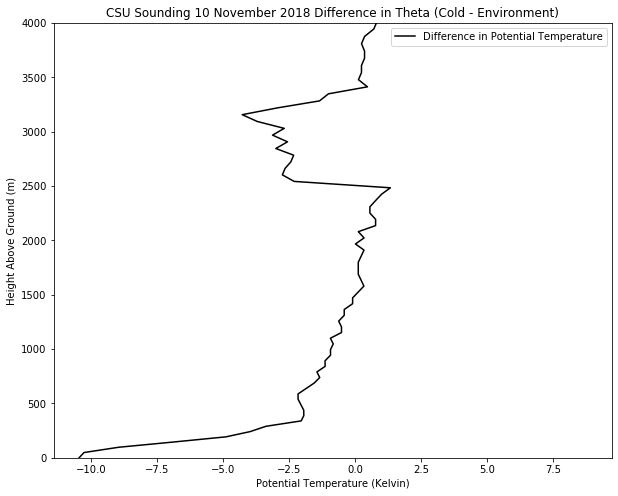

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
    
# Plot the Potential Temperature Values
ax.plot(theta_diff, agl_env, color = 'black', label='Difference in Potential Temperature')
    
# Make sure the vertical pressure axis is descending as it goes up

# Add a label to the axis for Potential Temperature
ax.set_xlabel('Potential Temperature (Kelvin)')

# Add a label to the axis for Pressure
ax.set_ylabel('Height Above Ground (m)')
plt.ylim(0, 4000)
plt.legend(loc='upper right')
    
# Add a title including the sounding location and the time of the sounding
plt.title('CSU Sounding 10 November 2018 Difference in Theta (Cold - Environment)')

Text(0.5, 1.0, 'CSU Sounding 10 November 2018 Difference in Theta-e (Cold - Environment)')

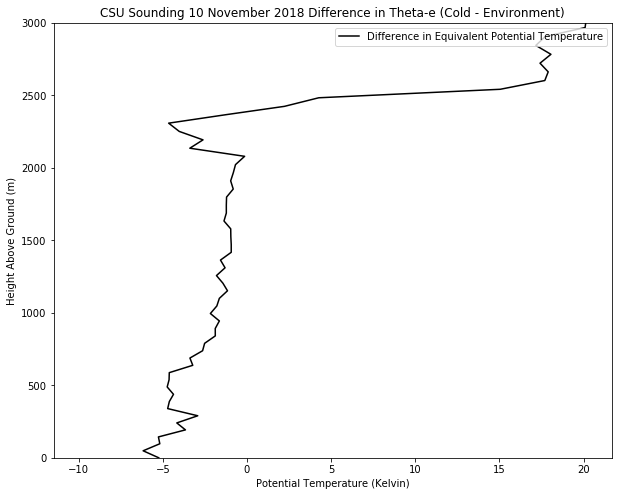

In [15]:
theta_e_diff = theta_e_cold - theta_e_env
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
    
# Plot the Potential Temperature Values
ax.plot(theta_e_diff, agl_env, color = 'black', label='Difference in Equivalent Potential Temperature')
    
# Make sure the vertical pressure axis is descending as it goes up

# Add a label to the axis for Potential Temperature
ax.set_xlabel('Potential Temperature (Kelvin)')

# Add a label to the axis for Pressure
ax.set_ylabel('Height Above Ground (m)')
plt.ylim(0, 3000)
plt.legend(loc='upper right')
    
# Add a title including the sounding location and the time of the sounding
plt.title('CSU Sounding 10 November 2018 Difference in Theta-e (Cold - Environment)')

Text(0.5, 1.0, 'CSU Sounding 10 November 2018 Difference in Theta-v (Cold - Environment)')

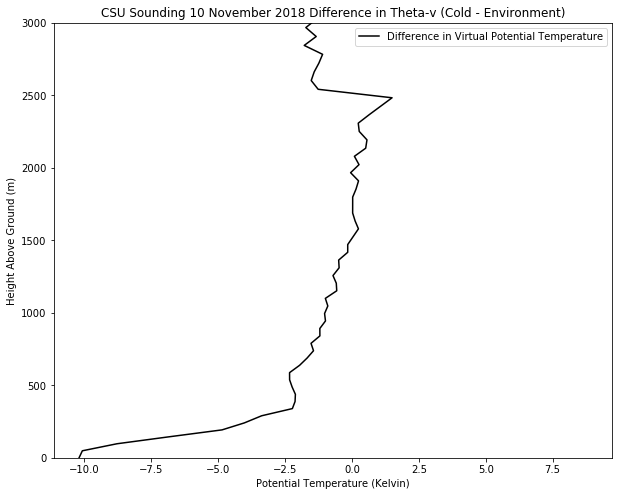

In [16]:
theta_w_diff = theta_w_cold - theta_w_env
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
    
# Plot the Potential Temperature Values
ax.plot(theta_w_diff, agl_env, color = 'black', label='Difference in Virtual Potential Temperature')
    
# Make sure the vertical pressure axis is descending as it goes up

# Add a label to the axis for Potential Temperature
ax.set_xlabel('Potential Temperature (Kelvin)')

# Add a label to the axis for Pressure
ax.set_ylabel('Height Above Ground (m)')
plt.ylim(0, 3000)
plt.legend(loc='upper right')
    
# Add a title including the sounding location and the time of the sounding
plt.title('CSU Sounding 10 November 2018 Difference in Theta-v (Cold - Environment)')